In [1]:
!pip install bar-chart-race==0.1.0

     |████████████████████████████████| 163kB 5.5MB/s 


In [2]:
# import modules and packages

%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import bar_chart_race as bcr
import statsmodels.api as sm
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 60)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# define font and figure size of graph
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams.update({'font.size': 22})

In [4]:
time_series_data = 'https://raw.githubusercontent.com/ajakaiye33/covid19Naija/master/covid19Naija/data/Records_covid19.csv'
non_time_series_data = 'https://raw.githubusercontent.com/ajakaiye33/covid19Naija/master/covid19Naija/data/cases19092020.csv'

In [5]:
#Loading Data

def load_tm_data():
    #print('f Loading data from {filename} ...')
    df = pd.read_csv(time_series_data, parse_dates=['Dates'], index_col='Dates')
    print(f'shape of data {df.shape}')
    print(f'checking for missing values {df.info()}')
    return df

def load_ntm_data():
    #print(f'Loading data from .. {file_name}')
    df = pd.read_csv(non_time_series_data)
    print(f'shape of data: {df.shape}')
    print(f'checking for missing data: {df.info()}')
    return df

#deathby_state = pd.read_csv('data/cases27062020.csv')

In [6]:

covid_ng2 = load_ntm_data()

shape of data: (37, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   States Affected               37 non-null     object
 1   No. of Cases (Lab Confirmed)  37 non-null     object
 2   No. of Cases (on admission)   37 non-null     object
 3   No. Discharged                37 non-null     object
 4   No. of Deaths                 37 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 1.6+ KB
checking for missing data: None


In [7]:
covid_ng = load_tm_data()

shape of data (212, 40)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 212 entries, 2020-02-27 15:40:00 to 2020-09-18 15:21:00
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Lagos                212 non-null    int64
 1   Abuja(FCT)           212 non-null    int64
 2   Kano                 212 non-null    int64
 3   Ogun                 212 non-null    int64
 4   Osun                 212 non-null    int64
 5   Gombe                212 non-null    int64
 6   Katsina              212 non-null    int64
 7   Borno                212 non-null    int64
 8   Edo                  212 non-null    int64
 9   Oyo                  212 non-null    int64
 10  Kwara                212 non-null    int64
 11  Akwa Ibom            212 non-null    int64
 12  Bauchi               212 non-null    int64
 13  Kaduna               212 non-null    int64
 14  Ekiti                212 non-null    int64
 15  Ondo         

In [8]:
#format header columns
def clean_col(name):
    #print('pretifying the column names')
    pretify_name = name.strip().lower().replace(" ", "_").replace('/','_')
    return pretify_name


## clean columns
clean_covid_ng2 = covid_ng2.rename(columns=clean_col)
clean_covid_ng = covid_ng.rename(columns=clean_col)
columns = {}
for col in clean_covid_ng.columns:
    if col == 'abuja(fct)':
        columns['abuja(fct)'] = 'abuja'
    elif col == 'dealth':
        columns['dealth'] = 'deaths'
    elif col == 'dischared_revovered':
        columns['dischared_revovered'] = 'discharged_recovered'
clean_covid_ng.rename(columns=columns, inplace=True)

In [9]:
## see columns
clean_covid_ng2.columns.to_list()
for i,j in enumerate(clean_covid_ng.columns.to_list()):
    print(i,j)

0 lagos
1 abuja
2 kano
3 ogun
4 osun
5 gombe
6 katsina
7 borno
8 edo
9 oyo
10 kwara
11 akwa_ibom
12 bauchi
13 kaduna
14 ekiti
15 ondo
16 delta
17 rivers
18 jigawa
19 enugu
20 niger
21 abia
22 zamfara
23 sokoto
24 benue
25 anambra
26 adamawa
27 plateau
28 imo
29 kebbi
30 kogi
31 nasarawa
32 taraba
33 yobe
34 bayelsa
35 ebonyi
36 cross_river
37 discharged_recovered
38 deaths
39 total_daily_cases


In [10]:
#south_west = ['lagos', 'ondo', 'osun','oyo','ekiti','ogun']


#Extract geopolitical zone
def extract_features(df):
    df['south_west'] = df['lagos'] + df['ondo'] + df['osun'] + df['oyo'] + df['ekiti'] + df['ogun']
    df['south_south'] = df['edo'] + df['rivers'] + df['delta'] + df['cross_river'] + df['bayelsa'] + df['akwa_ibom']
    df['south_east'] = df['anambra'] + df['imo'] + df['enugu'] + df['abia'] + df['ebonyi']
    df['north_central'] = df['benue'] + df['kogi'] + df['nasarawa'] + df['niger'] + df['plateau'] + df['kwara'] + df['abuja']
    df['north_east'] = df['adamawa'] + df['bauchi'] + df['borno'] + df['gombe'] + df['taraba'] + df['yobe']
    df['north_west'] = df['jigawa'] + df['kaduna'] + df['kano'] + df['katsina'] + df['kebbi'] + df['sokoto'] + df['zamfara']
    return df.head(2)


In [11]:
extract_features(clean_covid_ng)


lagos  abuja  kano  ogun  osun  gombe  katsina  borno  \
Dates                                                                        
2020-02-27 15:40:00      1      0     0     0     0      0        0      0   
2020-02-28 01:00:00      0      0     0     0     0      0        0      0   

                     edo  oyo  kwara  akwa_ibom  bauchi  kaduna  ekiti  ondo  \
Dates                                                                          
2020-02-27 15:40:00    0    0      0          0       0       0      0     0   
2020-02-28 01:00:00    0    0      0          0       0       0      0     0   

                     delta  rivers  jigawa  enugu  niger  abia  zamfara  \
Dates                                                                     
2020-02-27 15:40:00      0       0       0      0      0     0        0   
2020-02-28 01:00:00      0       0       0      0      0     0        0   

                     sokoto  benue  anambra  adamawa  plateau  imo  kebbi  \
Dates                                                                       
2020-02-27 15:40:00       0      0        0        0        0    0      0   
2020-02-28 01:00:00       0      0        0        0        0    0      0   

                     kogi  nasarawa  taraba  yobe  bayelsa  ebonyi  \
Dates                                                                
2020-02-27 15:40:00     0         0       0     0        0       0   
2020-02-28 01:00:00     0         0       0     0        0       0   

                     cross_river  discharged_recovered  deaths  \
Dates                                                            
2020-02-27 15:40:00            0                     0       0   
2020-02-28 01:00:00            0                     0       0   

                     total_daily_cases  south_west  south_south  south_east  \
Dates                                                                         
2020-02-27 15:40:00                  1           1            0           0   
2020-02-28 01:00:00                  0           0            0           0   

                     north_central  north_east  north_west  
Dates                                                       
2020-02-27 15:40:00              0           0           0  
2020-02-28 01:00:00              0           0           0

In [12]:
#extract model data
def m_data(df):
    m_data = df[['total_daily_cases', 'deaths', 'discharged_recovered']]
    return m_data
model_data = m_data(clean_covid_ng)

# extract Geopolitcal zone
def zones(df):
    zone_data = df[['south_west','south_south', 'south_east', 'north_central','north_east','north_west']]
    melt_zone = zone_data.melt(value_vars=['south_west','south_south', 'south_east', 'north_central','north_east','north_west'],
                                 var_name='geopolitical_zones', value_name='daily_zone_cases')
    group_by_zone = melt_zone.groupby('geopolitical_zones').agg({'daily_zone_cases': 'sum'}).reset_index()
    sort_by_zonal_cases =  group_by_zone.sort_values('daily_zone_cases', ascending=False)
    return sort_by_zonal_cases
    
geopolitical_zone = zones(clean_covid_ng)
geopolitical_zone

geopolitical_zones  daily_zone_cases
5         south_west             26525
0      north_central             10910
4        south_south              7398
2         north_west              5562
3         south_east              3925
1         north_east              2641

## Cases By Geopolitical Zones

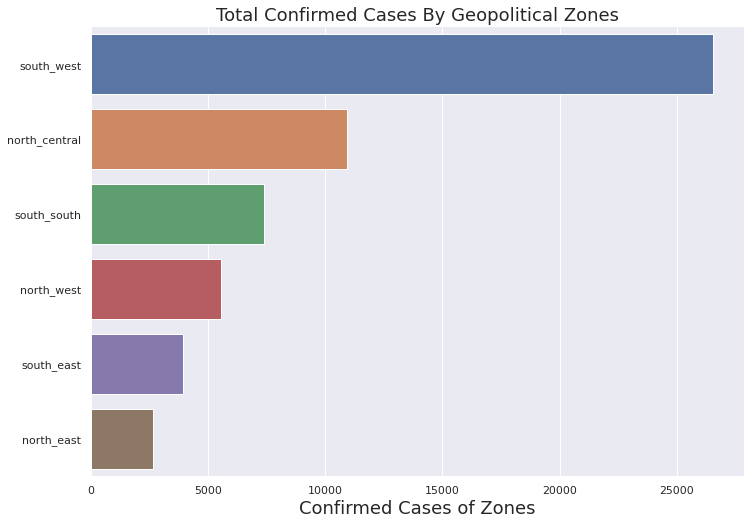

In [13]:
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='daily_zone_cases', y='geopolitical_zones', data=geopolitical_zone);
ax.set_title('Total Confirmed Cases By Geopolitical Zones', size = 18)
ax.set_xlabel('Confirmed Cases of Zones', size=18)
ax.set_ylabel('', size=18)
sns.despine(left=True)
plt.xticks(rotation=360)
plt.show()

## Medical Statistics

#### Case Fatality Rate(CFR)
$$\large CFR = \frac{Total Number of Death}{Total number Infected}$$

In [16]:
def case_fatality(df):
    total_death = df['deaths'].sum()
    total_confirm_cases = df['total_daily_cases'].sum()
    cfr = total_death/total_confirm_cases * 100
    return cfr
cfr = case_fatality(model_data)

print(f'The Case Fatality rate In Nigeria is: {round(cfr,1)}%')

The Case Fatality rate In Nigeria is: 1.9%


#### Mortality Rate
$$\large MR = \frac{Total Population}{Total Deaths}$$ 
[Estimated population of Nigeria](https://en.wikipedia.org/wiki/Demographics_of_Nigeria): 200 Million

In [17]:
def mortality_rate(df):
    estimated_population = 200000000
    covid_deaths = df['deaths'].sum()
    mr = covid_deaths/estimated_population
    return mr
mr = mortality_rate(model_data)
death_per1million = model_data['deaths'].sum()/1000000
print(f'The Mortality Rate of Covid19: {mr}, whereas deaths per one million is:{death_per1million}')

The Mortality Rate of Covid19: 5.47e-06, whereas deaths per one million is:0.001094


## Monthly Statistics

## Confirmed Cases By Month

In [18]:
def monthly_stats(df):
    #make_date_index = df.set_index(data_column)
    monthly_data = df.resample('M').agg({'deaths':'sum', 'total_daily_cases':'sum','discharged_recovered':'sum'})
    monthly_data['dates'] = monthly_data.index
    monthly_data['month'] = monthly_data['dates'].dt.month
    return monthly_data.drop('dates', axis=1)
df_month = monthly_stats(model_data)
df_month


deaths  total_daily_cases  discharged_recovered  month
Dates                                                             
2020-02-29       0                  1                     0      2
2020-03-31       2                137                     9      3
2020-04-30      56               1792                   310      4
2020-05-31     229               8232                  2688      5
2020-06-30     303              15533                  6739      6
2020-07-31     289              17457                  9819      7
2020-08-31     134              10844                 22073      8
2020-09-30      81               2948                  6667      9

### Monthly Confirmed Cases

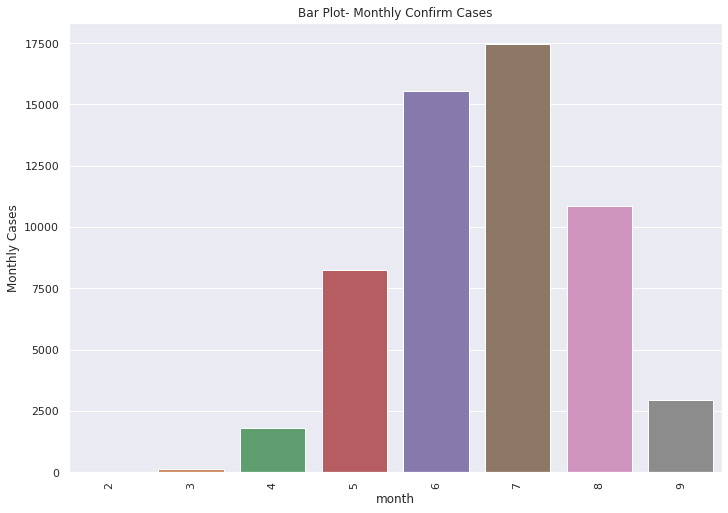

In [19]:
# Monthly confirmed cases
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='month', y='total_daily_cases', data=df_month)
ax.set_title('Bar Plot- Monthly Confirm Cases')
ax.set_ylabel('Monthly Cases')
plt.xticks(rotation = 90)
plt.show()

## Deaths By Month

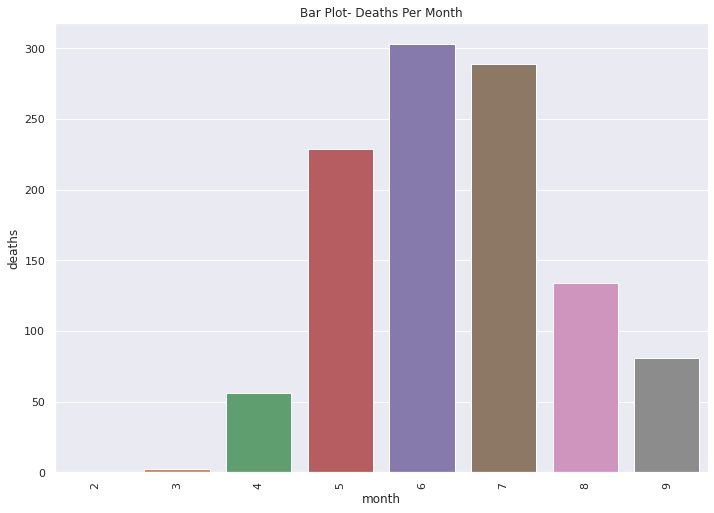

In [20]:
#Monthly Deaths
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='month', y='deaths', data=df_month)
ax.set_title('Bar Plot- Deaths Per Month')
plt.xticks(rotation = 90)
plt.show()

## Recoveries By Month

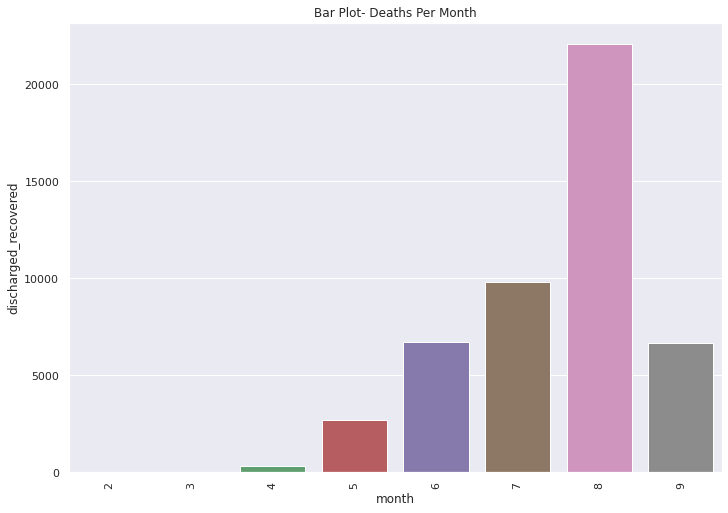

In [21]:
#Number of Recoveries by Month
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='month', y='discharged_recovered', data=df_month)
ax.set_title('Bar Plot- Deaths Per Month')
plt.xticks(rotation = 90)
plt.show()

## States Data

In [22]:
state_data = load_ntm_data()
state_data.head()

shape of data: (37, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   States Affected               37 non-null     object
 1   No. of Cases (Lab Confirmed)  37 non-null     object
 2   No. of Cases (on admission)   37 non-null     object
 3   No. Discharged                37 non-null     object
 4   No. of Deaths                 37 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 1.6+ KB
checking for missing data: None


States Affected No. of Cases (Lab Confirmed) No. of Cases (on admission)  \
0           Lagos                       18,827                       3,377   
1             FCT                        5,526                         537   
2             Oyo                        3,226                         985   
3         Plateau                        3,192                         886   
4             Edo                        2,611                          79   

  No. Discharged  No. of Deaths  
0         15,245            205  
1          4,913             76  
2          2,202             39  
3          2,275             31  
4          2,427            105

In [23]:
#clean_data
second_data = load_ntm_data()
affected_column = ['no._of_cases_(lab_confirmed)', 'no._of_cases_(on_admission)','no._discharged']
def polish_data(df):
    clean_columns = df.rename(columns=clean_col)
    for i in clean_columns.columns:
        if i in affected_column:
            clean_columns[i] = clean_columns[i].str.replace(',','').astype('int64')
    return clean_columns
cleany = polish_data(second_data)
cleany.head()

shape of data: (37, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   States Affected               37 non-null     object
 1   No. of Cases (Lab Confirmed)  37 non-null     object
 2   No. of Cases (on admission)   37 non-null     object
 3   No. Discharged                37 non-null     object
 4   No. of Deaths                 37 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 1.6+ KB
checking for missing data: None


states_affected  no._of_cases_(lab_confirmed)  no._of_cases_(on_admission)  \
0           Lagos                         18827                         3377   
1             FCT                          5526                          537   
2             Oyo                          3226                          985   
3         Plateau                          3192                          886   
4             Edo                          2611                           79   

   no._discharged  no._of_deaths  
0           15245            205  
1            4913             76  
2            2202             39  
3            2275             31  
4            2427            105

In [24]:
def states_stat(df,st_col, st_death):
    death_by_state =  df[[st_col, st_death]].sort_values(st_death, ascending=False)
    return death_by_state
death_by_states = states_stat(cleany,'states_affected', 'no._of_deaths')


## Deaths By States

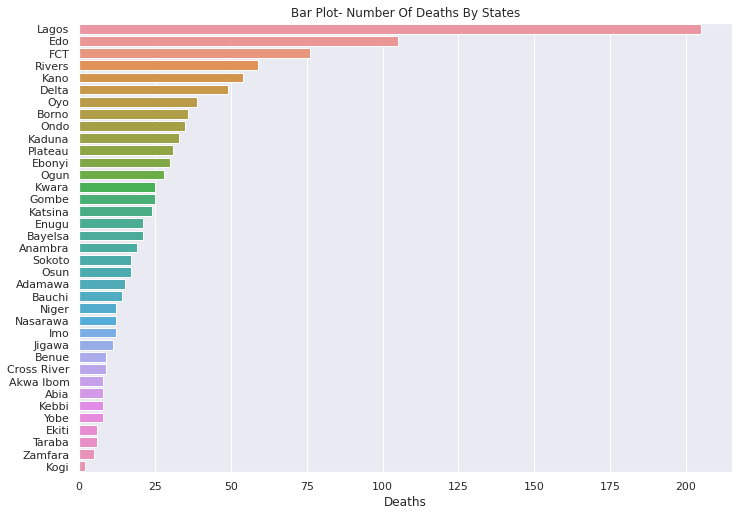

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='no._of_deaths', y='states_affected', data=death_by_states)
ax.set_title('Bar Plot- Number Of Deaths By States')
plt.xlabel('Deaths')
plt.ylabel('')
#plt.yticks(rotation=90)
plt.show()

## Recovery Rates By State

In [26]:
def recov_ratio(df, st_col, recov_col, conf_cases, new_col):
  df[new_col] = df[recov_col] / df[conf_cases]
  recovey_ratio = df[[st_col, new_col]].sort_values(new_col, ascending=False)
  return recovey_ratio
state_recov_ratio = recov_ratio(cleany, 'states_affected','no._discharged','no._of_cases_(lab_confirmed)','recov_ratio')
state_recov_ratio.head()

states_affected  recov_ratio
8             Ogun     0.977247
12          Ebonyi     0.970048
6           Rivers     0.959459
16            Osun     0.956790
24          Jigawa     0.956522

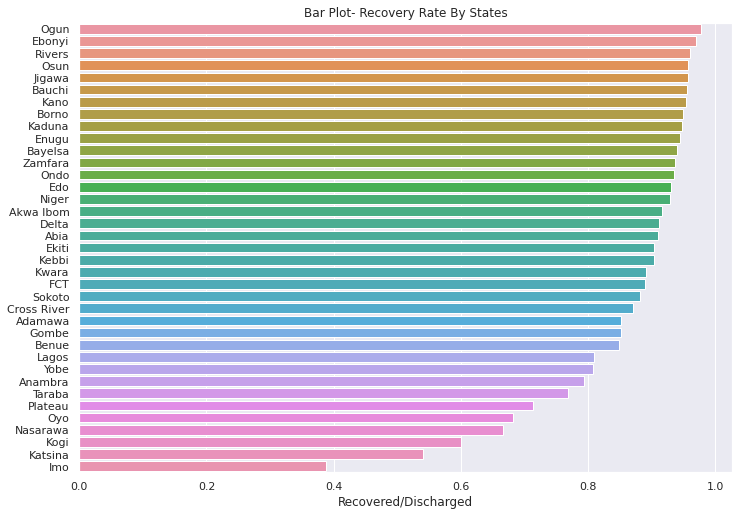

In [27]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='recov_ratio', y='states_affected', data=state_recov_ratio)
ax.set_title('Bar Plot- Recovery Rate By States')
plt.xlabel('Recovered/Discharged')
plt.ylabel('')
#plt.yticks(rotation=90)
plt.show()

## Recoveries/Discharged By States

In [28]:
discharged_by_states = states_stat(cleany, 'states_affected', 'no._discharged')


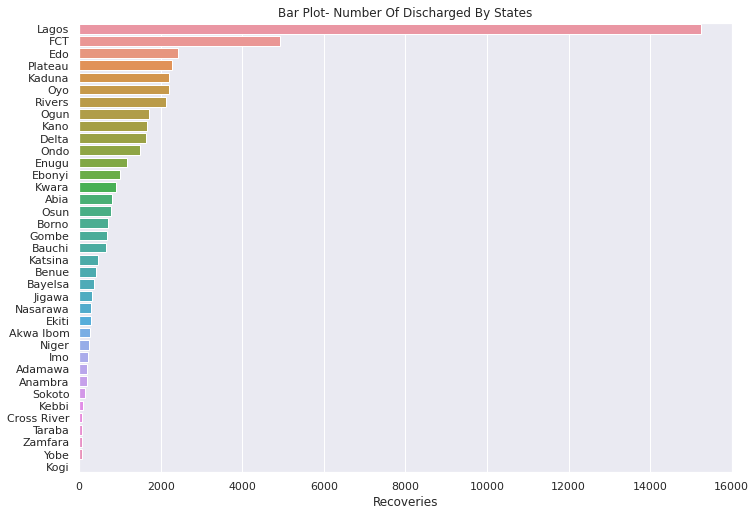

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='no._discharged',y='states_affected', data=discharged_by_states)
ax.set_title('Bar Plot- Number Of Discharged By States')
plt.xlabel('Recoveries')
plt.ylabel('')
#plt.xticks(rotation=90)
plt.show()

## confirmed Cases By States

In [30]:
confirmed_cases_states = states_stat(cleany,'states_affected', 'no._of_cases_(lab_confirmed)')


### Confirmed Cases By States

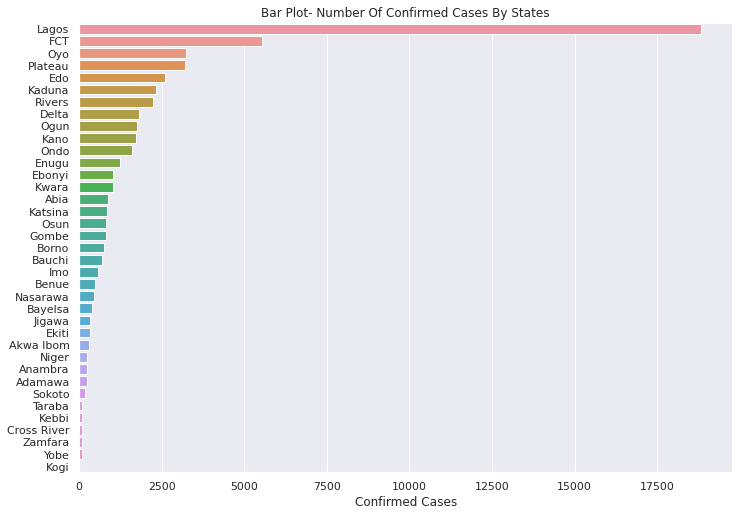

In [31]:
# Confirm cases spread across all states
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x='no._of_cases_(lab_confirmed)',y='states_affected', data=confirmed_cases_states)
ax.set_title('Bar Plot- Number Of Confirmed Cases By States')
plt.xlabel('Confirmed Cases')
plt.ylabel('')
#plt.xticks(rotation=90)
plt.show()

## Race Bar Chart

In [32]:
#get data into shape
nt_needed = ['discharged_recovered','deaths','total_daily_cases','south_west','south_south','south_east','north_central','north_east','north_west']
def tidyrc_data(df):
    race_chart_data = df.drop(nt_needed, axis=1)
    clean_rc_data = race_chart_data.cumsum(axis=0)
    return clean_rc_data

clean_rb = tidyrc_data(clean_covid_ng)



In [33]:
bcr.bar_chart_race(clean_rb)

## Build  Logistic Model

### Predicting the Epidemic Situation of Covid19 In Nigeria with Logistic Mathematical Model
My choice of the Logistic Model is simply because it is simple and it conform to the statistical law of Epidemiology

In [77]:
#Preapre data
def clean_model_data(df):
    cumulate_data = df.cumsum(axis=0)
    clean_index = cumulate_data.reset_index()
    return clean_index
log_model_data = clean_model_data(model_data)


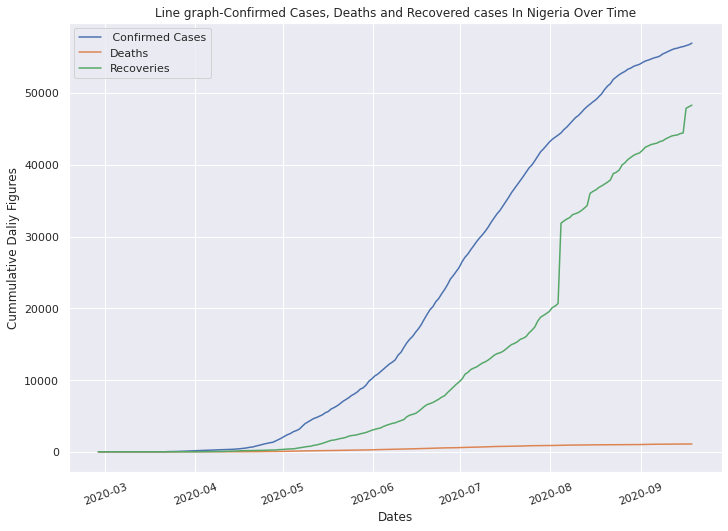

In [78]:
#Line graph of confirm cases over time
ax = sns.lineplot(x='Dates', y='total_daily_cases', data=log_model_data, label=' Confirmed Cases')
ax = sns.lineplot(x='Dates', y='deaths', data=log_model_data,label='Deaths')
ax = sns.lineplot(x='Dates', y='discharged_recovered', data=log_model_data, label='Recoveries')
plt.xticks(rotation=20)
ax.set_title('Line graph-Confirmed Cases, Deaths and Recovered cases In Nigeria Over Time')
ax.set_ylabel('Cummulative Daliy Figures')
ax.legend()
plt.show()




## Logistic Model
The logistic model can be simply rendered as $$\huge f(x;a,b,c) = \frac{c}{1 + e^-(x-b)/a}$$ 

where :
- a = **Infection speed**
- b = **Day with maximum Infections Occured**
- c = **Total Number of people that would be infected at the end of the pandemic**

In [101]:
def logistic_model(x,a,b,c,d):
    return a / (1 + np.exp(-c * (x - d))) + b

# def logistics_noise(a,b,c,d,t):
#     return abs(c/(1+a*np.exp(-b*t))+np.random.normal(0,d))

In [102]:
def build_data(df):
    df['time_stamp'] = df.index
    return df
build_model = build_data(log_model_data)
build_model.tail()

Dates  total_daily_cases  deaths  discharged_recovered  \
207 2020-09-14 15:21:00              56376    1083                 44337   
208 2020-09-15 15:21:00              56466    1088                 44430   
209 2020-09-16 15:21:00              56592    1091                 47872   
210 2020-09-17 15:21:00              56723    1093                 48092   
211 2020-09-18 15:21:00              56944    1094                 48305   

     time_stamp                  ds      y           cap  
207         207 2020-09-14 15:21:00  56376  58602.886981  
208         208 2020-09-15 15:21:00  56466  58602.886981  
209         209 2020-09-16 15:21:00  56592  58602.886981  
210         210 2020-09-17 15:21:00  56723  58602.886981  
211         211 2020-09-18 15:21:00  56944  58602.886981

In [103]:
# extract x(days) & y(cases) from dataframe
x = list(build_model.iloc[:,4])
y = list(build_model.iloc[:,1])


In [104]:
# randomly initialize a,b,c,d
p0 = np.random.exponential(size=4)
p0


array([0.91086383, 0.0442771 , 1.12836925, 3.73060264])

In [105]:
# set upper and lower bounds a,b,c
bounds = (0,[10000000., 1., 100000000., 100000000.])
#bounds = ((-np.inf, -np.inf, 0, 0), (np.inf, np.inf, 1, 1))
bounds

(0, [10000000.0, 1.0, 100000000.0, 100000000.0])

In [106]:
(a_, b_, c_,d_), cov = curve_fit(logistic_model,x,y,bounds=bounds, p0=p0)

In [107]:
a_,b_,c_,d_

(58602.884564760796,
 7.432136893220734e-15,
 0.04343474926384345,
 137.77249670209255)

In [108]:
#the time step at which the growth is fastest
# t_fastest = np.log(a) / b
# i_fastest = logistic_model(t_fastest, a, b, c)
# i_fastest

In [109]:
conex = np.array(y)
conex

array([    1,     1,     1,     1,     1,     1,     1,     1,     1,
           1,     1,     2,     2,     2,     2,     2,     2,     2,
           2,     3,     3,     3,     3,     6,    27,    39,    43,
          45,    50,    64,    69,    80,    88,    96,   110,   130,
         134,   138,   150,   173,   183,   189,   213,   223,   231,
         237,   253,   275,   289,   306,   319,   324,   344,   363,
         374,   408,   443,   494,   543,   629,   667,   784,   875,
         983,  1097,  1184,  1270,  1335,  1530,  1726,  1930,  2168,
        2388,  2557,  2802,  2950,  3145,  3525,  3911,  4150,  4398,
        4640,  4786,  4968,  5157,  5445,  5621,  5959,  6167,  6393,
        6677,  7016,  7261,  7526,  7839,  8068,  8344,  8733,  8915,
        9302,  9855, 10162, 10578, 10819, 11167, 11517, 11845, 12227,
       12487, 12802, 13465, 13874, 14555, 15182, 15683, 16086, 16659,
       17149, 17736, 18481, 19148, 19809, 20245, 20920, 21372, 22021,
       22615, 23299,

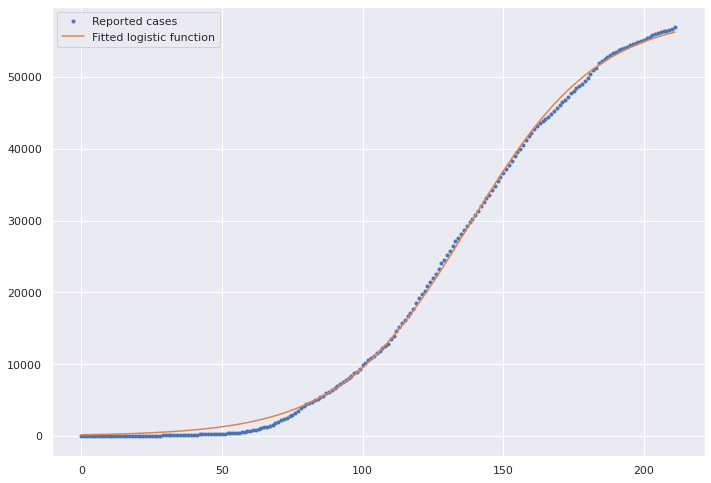

In [110]:
def plot_logistic_fit(confirmed, logistic_params):
    a_, b_, c_,d_ = logistic_params
    x = np.arange(0, len(build_model['time_stamp']))
    plt.plot(x, confirmed, ".", label="Reported cases")
    confirmed_pred = logistic_model(x, a_, b_, c_,d_)
    plt.plot(x, confirmed_pred, label="Fitted logistic function")
    plt.legend()
    plt.show()
    return confirmed_pred
confirmed_pred = plot_logistic_fit(conex, (a_, b_, c_,d_))


In [111]:
from sklearn.metrics import r2_score

In [112]:
#check goodness of fit measure
r2_score(y,confirmed_pred)

0.999224726499771

In [113]:
def plateau(confirmed, logistic_params,diff=200):
  a_, b_, c_, d_ = logistic_params
  confirm_now = confirmed[-1]
  confirmed_then = confirmed[-2]
  days = 0
  now = x[-1]
  while confirm_now - confirmed_then > diff:
    days += 1
    confirmed_then = confirm_now
    confirm_now = logistic_model(now + days, a_, b_, c_, d_)
  return days, confirm_now
days, confirmy = plateau(y,(a_, b_, c_, d_))
days, confirmy

(1, 56360.12099998978)

In [114]:
print(f"last day's case:{conex[-1] - conex[-2]}")


last day's case:221


## Focasting with Facebook's Prophet Package
To use this package for logistic growth, a carrying capacity mst be estimated/calculated

In [115]:
# carrying cappacity from above logistic growth model
t_fastest = np.log(a_)/b_
t_fastest

1477171284213342.2

In [116]:
check_fastest = logistic_model(t_fastest, a_, b_, c_, d_)
check_fastest

58602.884564760796

In [117]:
# wrangle dataframe to fit prophet requirement
def forecast_data(df):
  df['ds'] = df['Dates']
  df['y'] = df['total_daily_cases'] 
  df['cap'] = check_fastest
  prof_df = df[['ds', 'y', 'cap']]
  return prof_df
prophet_data =  forecast_data(build_model)
prophet_data.head()


ds  y           cap
0 2020-02-27 15:40:00  1  58602.884565
1 2020-02-28 01:00:00  1  58602.884565
2 2020-02-29 02:26:00  1  58602.884565
3 2020-03-01 22:44:00  1  58602.884565
4 2020-03-02 11:53:00  1  58602.884565

In [118]:
m = Prophet(growth='logistic')
m.fit(prophet_data)
future = m.make_future_dataframe(periods=30)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [119]:
future['cap'] = prophet_data['cap'].iloc[0]
forecast = m.predict(future)

In [120]:
forecast.tail()

ds         trend           cap    yhat_lower  \
237 2020-10-14 15:21:00  58082.739098  58602.884565  57087.772900   
238 2020-10-15 15:21:00  58107.569349  58602.884565  57195.617417   
239 2020-10-16 15:21:00  58131.223901  58602.884565  57186.593925   
240 2020-10-17 15:21:00  58153.757523  58602.884565  57163.599680   
241 2020-10-18 15:21:00  58175.222521  58602.884565  57185.523029   

       yhat_upper   trend_lower   trend_upper  additive_terms  \
237  57975.905799  58071.520506  58094.182261     -567.345995   
238  58065.033587  58096.168594  58119.177157     -494.639724   
239  58038.650742  58119.773898  58143.192020     -503.045030   
240  58056.441026  58142.209192  58165.525836     -540.638711   
241  58032.844719  58163.534883  58187.339724     -562.854210   

     additive_terms_lower  additive_terms_upper       daily  daily_lower  \
237           -567.345995           -567.345995 -541.167569  -541.167569   
238           -494.639724           -494.639724 -541.167569  -541.167569   
239           -503.045030           -503.045030 -541.167569  -541.167569   
240           -540.638711           -540.638711 -541.167569  -541.167569   
241           -562.854210           -562.854210 -541.167569  -541.167569   

     daily_upper     weekly  weekly_lower  weekly_upper  multiplicative_terms  \
237  -541.167569 -26.178425    -26.178425    -26.178425                   0.0   
238  -541.167569  46.527846     46.527846     46.527846                   0.0   
239  -541.167569  38.122540     38.122540     38.122540                   0.0   
240  -541.167569   0.528858      0.528858      0.528858                   0.0   
241  -541.167569 -21.686640    -21.686640    -21.686640                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper          yhat  
237                         0.0                         0.0  57515.393104  
238                         0.0                         0.0  57612.929626  
239                         0.0                         0.0  57628.178871  
240                         0.0                         0.0  57613.118812  
241                         0.0                         0.0  57612.368311

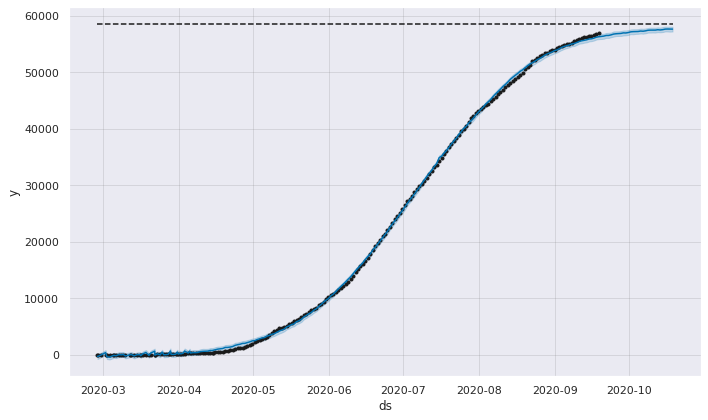

In [121]:
fig = m.plot(forecast)

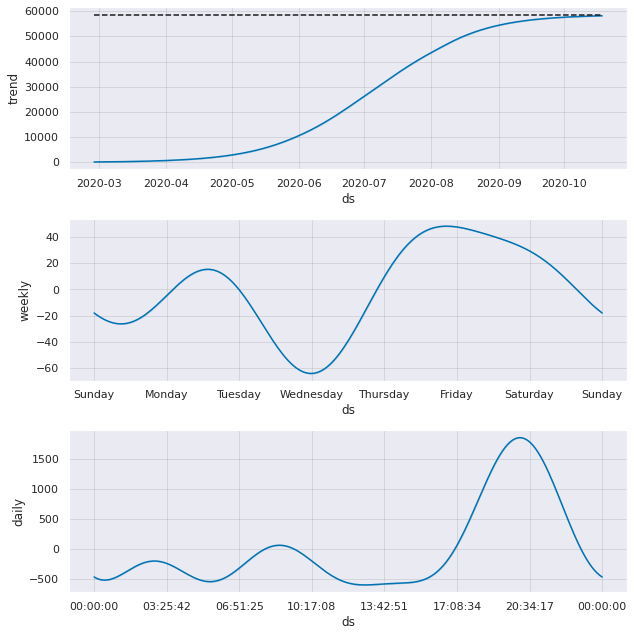

In [122]:
fig2 = m.plot_components(forecast)